Hierarchical Linear Regression in PyMC2
================================


$$\\[2pt]$$


Igor Marfin **[Unister Gmb@2014]** < <igor.marfin@unister.de>>


$$\\[40pt]$$


Abstract
----------------


--------------------------

More details on this study can be found in my **bitbucket repository** https://bitbucket.org/iggy_floyd/bayesian-pymc-linear-regression-model.
Writting this tutorial was inspired by the  blog [[1]](#Blog). I would like to quote a few statements as my motivation:



>In this blog post we will:
    provide and intuitive explanation of hierarchical/multi-level Bayesian modeling;
    show how this type of model can easily be built and estimated in PyMC2;
    demonstrate the advantage of using hierarchical Bayesian modelling as opposed to non-hierarchical Bayesian modelling by comparing the two;
    visualize the "shrinkage effect" (explained below); and


>Having multiple sets of related measurements comes up all the time. In mathematical psychology, for example, you test multiple subjects on the same task. We then want to estimate a computational/mathematical model that describes the behavior on the task by a set of parameters. We could thus fit a model to each subject individually, assuming they share no similarities; or, pool all the data and estimate one model assuming all subjects are identical. Hierarchical modeling allows the best of both worlds by modeling subjects' similarities but also allowing estimiation of individual parameters. As an aside, software from our lab, HDDM, allows hierarchical Bayesian estimation of a widely used decision making model in psychology. In this blog post, however, we will use a more classical example of hierarchical linear regression to predict radon levels in houses.


$$\\[5pt]$$
Outline
------------------


------------------


* Abstract
* Initialization of the notebook
* Getting and cleaning the data
* The Model
  * Model based on pooled measurements
    * Diagnostics
  * Model based on unpooled measurements
  * Model based on partly-pooled measurements
* Visualization of predictions
  * Plotting of the fitted parameters
  * Shrinkage plot
  * Plotting of radon levels of different counties. 
* Goodness of the Fit(GoF)
  * Geweke statistics
  * 95% CI and Gelman-Rubin statistics plots 
  * Freeman-Tukey statistics and discrepancy plots  
* Optional matherial
  * The model with group-level predictors
* References

$$\\[5pt]$$
Initialization 
--------------------------

________

To set up the python environment for the data analysis and make a nicer style of the notebook, one can run the following commands in the beginning of our modeling:


In [11]:
import sys
sys.path = ['/usr/local/lib/python2.7/dist-packages'] + sys.path # to fix the problem with numpy: this replaces  1.6 version by 1.9

%matplotlib inline
%pylab inline
ion()

import os
import matplotlib 
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import logging
import pymc as pm

# a plotter and dataframe modules
import seaborn as  sns # seaborn to make a nice plots of the data
import pandas as pd
import scipy.stats as stats





# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from book_format import load_style, figsize, set_figsize
load_style(".","/styles/custom2.css")



Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


$$\\[5pt]$$
Getting and cleaning the data
-------------


--------------------------

Today we are going to explore the presence of the radon gas  in housesholds of the USA.
Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil.

<img src="http://www.fix-your-radon.com/images/how_radon_enters.jpg" width = 300/>

The Gelman et al.'s (2007) radon dataset would be a classic for hierarchical modeling.


We'll try to make predictions of radon levels in different counties based on the county itself and the presence of a basement. 

In this tutorial we'll look at Minnesota, a state that contains 85 counties in which different measurements are taken, ranging from 2 to 116 measurements per county. 





First, we'll load the data from the github.com repository of the blog author: 

In [2]:
!mkdir data
!wget https://raw.githubusercontent.com/twiecki/WhileMyMCMCGentlySamples/master/content/downloads/notebooks/radon.csv -O data/radon.csv

mkdir: cannot create directory `data': File exists
--2015-08-08 13:28:29--  https://raw.githubusercontent.com/twiecki/WhileMyMCMCGentlySamples/master/content/downloads/notebooks/radon.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.31.17.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.31.17.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157833 (154K) [text/plain]
Saving to: `data/radon.csv'

100%[======================================>] 157,833      636K/s   in 0.2s    

2015-08-08 13:28:32 (636 KB/s) - `data/radon.csv' saved [157833/157833]



In [2]:
radon_data = pd.read_csv('data/radon.csv')
county_names = radon_data.county.unique()
county_idx = radon_data['county_code'].values
n_counties = len(radon_data.county.unique())

county_data=pd.DataFrame({
    "county_names":county_names,
    "county_idx": radon_data['county_code'].unique()      
    })

# example of the data we have
radon_data.head(4)

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,0,5081,MN,MN,27,55735,5,1,1,3,...,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054,0,0.832909
1,1,5082,MN,MN,27,55748,5,1,0,4,...,14.5,471.366223,0,0,1,AITKIN,27001,0.502054,0,0.832909
2,2,5083,MN,MN,27,55748,5,1,0,4,...,9.6,433.316718,0,0,1,AITKIN,27001,0.502054,0,1.098612
3,3,5084,MN,MN,27,56469,5,1,0,4,...,24.3,461.623670,0,0,1,AITKIN,27001,0.502054,0,0.095310


We are interested only in a few fields of this dataset:

* 'county' -- the name of the county where the measurements were done
* 'log_radon' -- the logarithm of the radon level
* 'floor' -- a binary variable, telling  whether the house has a basement (floor == 0) or not (floor == 1).

In [4]:
columns_of_interest=['county','log_radon','floor']
radon_data[columns_of_interest].head(4)

,county,log_radon,floor
0,AITKIN,0.832909,1
1,AITKIN,0.832909,0
2,AITKIN,1.098612,0
3,AITKIN,0.095310,0


As you can see, we have multiple radon measurements  -- one row for each house -- in a county and whether the house has a basement (floor == 0) or not (floor == 1). We are interested in whether having a basement increases the radon measured in the house. 

$$\\[5pt]$$
The Model
------------------


--------------------

There three possibilities. 

$$\\[5pt]$$
###Pooling of measurements
--------------------

Our model is defined as the following formula:

$$radon_{i,c}=\alpha+\beta\times floor_{i,c}+\varepsilon, $$

where $i$ represents the measurement, $c$ the county and floor contains a 0 or 1 if the house has a basement or not, respectively. Critically, we are only estimating one intercept and one slope for all measurements over all counties pooled together.


$$\\[5pt]$$
###Unpooled measurements: separate regressions
--------------------

Our model is:

$$radon_{i,c}=\alpha_c+\beta_c\times floor_{i,c}+\varepsilon_c, $$

where $i$ represents the measurement, $c$ the county and floor contains a 0 or 1 if the house has a basement or not, respectively. Note that we added the subindex $c$ so we are estimating $n$ different $\alpha$s and $\beta$s -- one for each county.


$$\\[5pt]$$
###Partial pooling: Hierarchical Regression aka the best of both worlds

Fortunately, there is a middle ground to both of these extremes. Specifically, we may assume that while $\alpha$s and $\beta$s are different for each county as in the unpooled case, the coefficients all share some similarity. 

We can model this by assuming that each individual coefficient comes from a common group distribution:


$$\alpha_c∼N(\mu_\alpha,\sigma^2_\alpha),$$
$$\beta_c∼N(\mu_\beta,\sigma^2_\beta).$$

We thus assume the intercepts $\alpha_c$ and slopes $\beta_c$ to come from a normal distribution centered around their respective group mean $\mu$ with a certain standard deviation $\sigma^2$, the values (or rather posteriors) of which we also estimate. That's why this is called a multilevel, hierarchical or partial-pooling modeling.


Before we consider all three cases, we want to create the skeleton (basic) class of our models as well as the code splitting the data on train/test datasets.


In [5]:

'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    A Base Class definitions.
'''


# Define a function for splitting train/test data.
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10%.
    """
    from sklearn.cross_validation import train_test_split

    train, test = train_test_split(data, test_size =percent_test)
    return train, test

# Define our evaluation function: RMSE - root mean squared error function
def rmse(test_data, predicted):      
    """
        Calculate root mean squared error.
        Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error    
    return np.sqrt(mse)  



# Define the Basic class
class BaseModel(object):
    """ Base Class"""

    def __init__(self, train_data):
        # how many periods of the measurement we have
        self.num_entries = len(train_data)
        self.data = train_data
        self.traces = None
        self.predicted = None

    def predict(self, train_data):
        raise NotImplementedError(
            'prediction not implemented for base class')

        
    def prepare_trace(self):
        raise NotImplementedError(
            'preparing the traces not implemented for base class')

        
    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""

        # rmse is a global function defined before
        return rmse(test_data, self.predicted)


$$\\[5pt]$$
Model based on pooled measurements
----------------------

-------


The code of the model is given below.

In [6]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    A Model based on the pooled data
'''


#defines the class for the Modeling
class ModelPooled(BaseModel):
    """ A ModelPooled class 
         :param np.ndarray data: The  data to use for learning the model.
         
    """


    def __init__(self, data):        
    
        logging.info('building the  model....') 
        super(ModelPooled,self).__init__( data )        

        alpha_value_init = np.mean(data.loc[data['floor'] == 0,'log_radon'].values)
        beta_value_init = np.mean(data.loc[data['floor'] == 1,'log_radon'].values)
        beta_value_init -= alpha_value_init
        
        # alpha and beta priors
        self.alpha = pm.Normal("alpha", 
                        mu=0., 
                        #tau=100,
                        tau=100**-1, # tau is singma^{-1}
                        value=alpha_value_init) 
            
        self.beta = pm.Normal("beta", 
                        mu=0., 
                        #tau=100,   
                        tau=100**-1,
                        value=beta_value_init) 
        
        #  error prior
        self.eps = pm.Uniform('eps', lower=0, upper=100)
        
        # log of the radon level
        # Linear model of the log of the radon level        
        @pm.deterministic
        def log_radon(alpha=self.alpha, 
            beta=self.beta, 
            floor=self.data["floor"].values): 
            return alpha+ beta*floor 
                

        # what we observed is           
        self.radon_observed = pm.Normal('radon_observed', 
                          mu=log_radon, 
                          tau=self.eps,
                          value=self.data["log_radon"].values, 
                          observed=True)
        
        # our model collects all definitions in self.model        
        self.model = pm.MCMC([self.alpha, self.beta,self.eps,log_radon,self.radon_observed])
        logging.info('done building the  model')



def _prepare_trace(self):
    ''' prepare a dataframe with traces of the alpha,beta and eps parameters of 
    our model
    '''
    self.traces = pd.DataFrame({'alpha': self.alpha.trace(), 
                                'beta': self.beta.trace(),
                                'eps': self.eps.trace(),
                               })
    return  self.traces


# Update the interface of our model
ModelPooled.prepare_trace = _prepare_trace
        
train,test = split_train_test(radon_data[columns_of_interest])
# fix of bug in the old sklearn
train,test=pd.DataFrame(train,columns=columns_of_interest),pd.DataFrame(test,columns=columns_of_interest)
train,test=train.convert_objects(convert_numeric=True),test.convert_objects(convert_numeric=True),

pooled_model= ModelPooled(train)
pooled_model.model.sample(100000, 5000, 20)

INFO:root:building the  model....
INFO:root:done building the  model


 [-----------------100%-----------------] 100000 of 100000 complete in 22.0 sec

$$\\[5pt]$$
Diagnostics
------------------


--------------------

Let's see if/how the model converged. 

Plotting alpha
Plotting beta


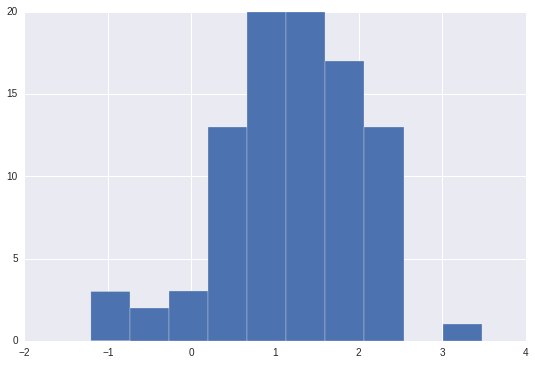

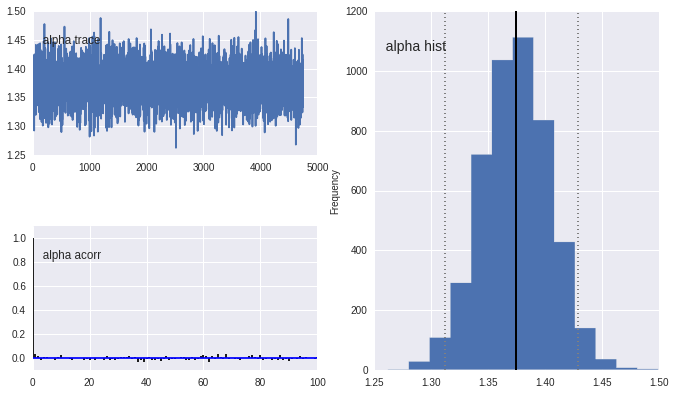

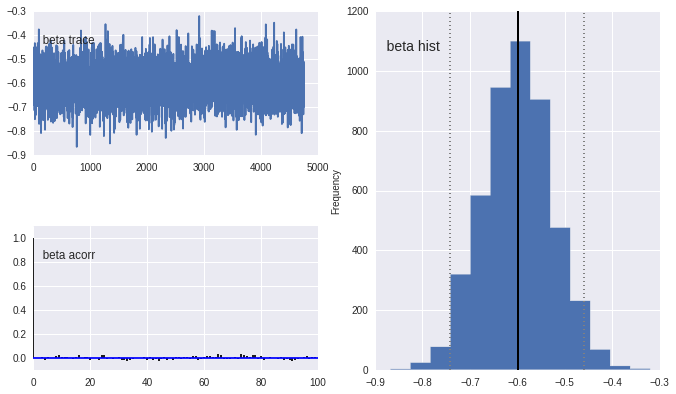

In [7]:
sns.set(style="darkgrid")

test["log_radon"].hist()

#  alpha parameter
pm.Matplot.plot(pooled_model.alpha,path='plots/')

#  beta parameter
pm.Matplot.plot(pooled_model.beta,path='plots/')

We need to extend our model by prediction method  to calculate the RMSE.

In [8]:
def _predict(self,test_data,alpha=None,beta=None,eps=None):
    ''' predicts results on the test data '''

    if (alpha is None): alpha = self.alpha.value
    if (beta is None): beta = self.beta.value
    if (eps is None): eps = self.eps.value
        
    self.predicted =np.random.normal(alpha + beta*test_data['floor'].values, eps)
    return self.predicted


# Update the interface of our model
ModelPooled.predict = _predict    


In [9]:
pooled_model.predict(train)
print "RMSE on train data: ", pooled_model.rmse(train["log_radon"].values)

pooled_model.predict(test)
print "RMSE on test data: ", pooled_model.rmse(test["log_radon"].values)

RMSE on train data:  1.86659266777
RMSE on test data:  1.85661665164


It is has a particular interest to see how RMSE develops in MCMC chain. We will introduce the function running_rmse to plot such behavior.

This is a so-called traceplot of the RSME. We'll compute RMSE for both the train and the test set, even though the convergence is indicated by RMSE on the training set alone. In addition, let's compute a running RMSE on the train/test sets to see how aggregate performance improves or decreases as we continue to sample.

In [10]:
def _running_rmse(self, test_data, train_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    
    traces = self.prepare_trace()
    burn_in = burn_in if len(traces) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}

    R_train = np.zeros(len(train_data))
    R_test = np.zeros(len(test_data))

    for cnt in range(burn_in,len(traces)):
        
        alpha = traces.loc[cnt,"alpha"]
        beta = traces.loc[cnt,"beta"]
        eps = traces.loc[cnt,"eps"]
        predicted_train = self.predict(train_data,alpha,beta,eps)
        predicted_test = self.predict(test_data,alpha,beta,eps)
        R_train += predicted_train
        R_test += predicted_test        
        running_R_train = R_train / (cnt + 1)
        running_R_test = R_test / (cnt + 1)
        
        results['per-step-train'].append(rmse(train_data["log_radon"].values, predicted_train))
        results['running-train'].append(rmse(train_data["log_radon"].values, running_R_train))
        results['per-step-test'].append(rmse(test_data["log_radon"].values, predicted_test))
        results['running-test'].append(rmse(test_data["log_radon"].values, running_R_test))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')

    # Return the final predictions, and the RMSE calculations
    return running_R_train,running_R_test, results


# Update the interface of ModelPooled
ModelPooled.running_rmse = _running_rmse

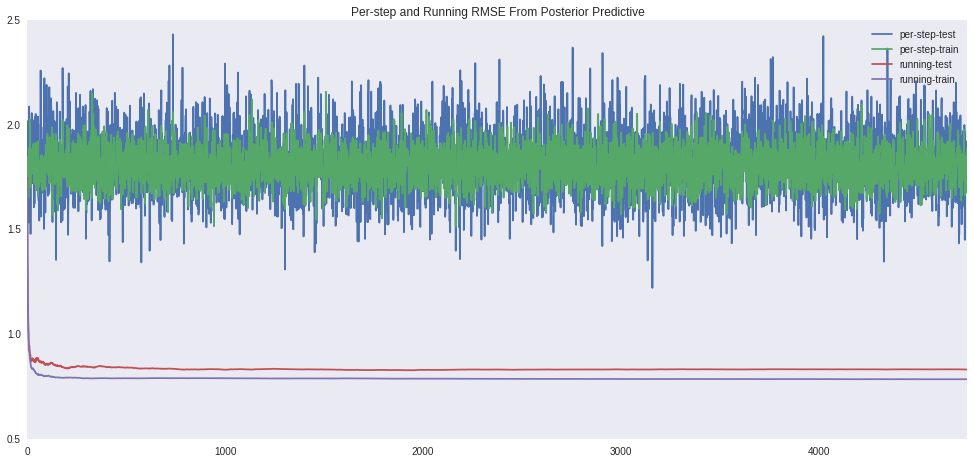

In [11]:
_,_,results_pooled=pooled_model.running_rmse(test, train, burn_in=5000)

In [12]:
results_pooled.tail(3)

,per-step-test,per-step-train,running-test,running-train
4747,1.767851,1.741515,0.831463,0.784821
4748,1.691075,1.716562,0.831458,0.784822
4749,1.914687,1.889621,0.831503,0.784813


$$\\[5pt]$$
Model based on unpooled measurements
----------------------

-------


The code of the model is given below.

In [182]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    A Model based on the unpooled data
'''


#defines the class for the Modeling
class ModelUnPooled(BaseModel):
    """ A ModelUnPooled class 
         :param np.ndarray data: The  data to use for learning the model.
         :param np.ndarray aux_data: The auxiliary data to use for learning the model.
         
    """


    def __init__(self, data,aux_data):        
    
        logging.info('building the  model....') 
        super(ModelUnPooled,self).__init__( data ) 
        
        
        self.aux_data = aux_data # the data contain name of the county and its id
        
        self.alphas={} # the container of alpha parameters for each county
        self.betas={}  # the container of beta parameters for each county
        self.epses={}  # the container of eps parameters for each county
        self.radon_observeds={}  # the container of observed for each county
        self.models={}  # the container of models for each county
        
        alpha_value_init = np.mean(data.loc[data['floor'] == 0,'log_radon'].values)
        beta_value_init = np.mean(data.loc[data['floor'] == 1,'log_radon'].values)
        beta_value_init -= alpha_value_init
           
        
        for idx in self.aux_data.index:
        
        
            county_name = self.aux_data.loc[idx,"county_names"]
            county_idx  =  self.aux_data.loc[idx,"county_idx"]
        
            print "Training %s ...."%county_name
            data_selected =self.data.ix[self.data.county == county_name]
        
            alpha_values=data_selected.loc[data_selected['floor'] == 0,'log_radon'].values
            alpha_value_init_local = np.mean(alpha_values) if (len(alpha_values)>0) else alpha_value_init            
            beta_values = data_selected.loc[data_selected['floor'] == 1,'log_radon'].values
            beta_value_init_local = np.mean(beta_values) if (len(beta_values)>0) else beta_value_init            
            beta_value_init_local -= alpha_value_init_local
            
            
            # alpha and beta priors    
            self.alphas["alpha_%d"%county_idx] =  pm.Normal("alpha_%d"%county_idx, 
                        mu=0., 
                        #tau=100,                         
                        tau=100**-1,   # tau is singma^{-1}                      
                        value=alpha_value_init_local) 
        
            self.betas["beta_%d"%county_idx] =  pm.Normal("beta_%d"%county_idx, 
                        mu=0., 
                        #tau=100,
                        tau=100**-1, # tau is singma^{-1}
                        value=beta_value_init_local) 

            self.epses["eps_%d"%county_idx] = pm.Uniform("eps_%d"%county_idx, 
                         lower=0, upper=100)
        
            
        
            # log of the radon level
            # Linear model of the log of the radon level        
            @pm.deterministic
            def log_radon(alpha=self.alphas["alpha_%d"%county_idx], 
                beta=self.betas["beta_%d"%county_idx], 
                floor=data_selected["floor"].values): 
                return alpha+ beta*floor 
                

            # what we observed is           
            self.radon_observeds["radon_observed_%d"%county_idx]  =  pm.Normal("radon_observed_%d"%county_idx, 
                          mu=log_radon, 
                          tau=self.epses["eps_%d"%county_idx],
                          value=data_selected["log_radon"].values, 
                          observed=True)
        
            
            # our model collects all definitions in self.model        
            self.models["model_%d"%county_idx] = pm.MCMC([
                    self.alphas["alpha_%d"%county_idx], 
                    self.betas["beta_%d"%county_idx],
                    self.epses["eps_%d"%county_idx],
                    log_radon,
                    self.radon_observeds["radon_observed_%d"%county_idx]
                ])
            self.models["model_%d"%county_idx].sample(20000, 5000, 20)
            #self.models["model_%d"%county_idx].sample(100000)
            print
            print "Remains: %d ...."%(len(self.aux_data)-idx-1)
            
        logging.info('...done building the  model')

unpooled_model= ModelUnPooled(train,county_data)


INFO:root:building the  model....


Training AITKIN ....
 [-----------------100%-----------------] 20000 of 20000 complete in 2.4 sec
Remains: 84 ....
Training ANOKA ....
 [-----------------100%-----------------] 20000 of 20000 complete in 2.5 sec
Remains: 83 ....
Training BECKER ....
 [-----------------100%-----------------] 20000 of 20000 complete in 2.4 sec
Remains: 82 ....
Training BELTRAMI ....
 [-----------------100%-----------------] 20000 of 20000 complete in 2.4 sec
Remains: 81 ....
Training BENTON ....
 [-----------------100%-----------------] 20000 of 20000 complete in 2.4 sec
Remains: 80 ....
Training BIG STONE ....
 [-----------------100%-----------------] 20000 of 20000 complete in 2.4 sec
Remains: 79 ....
Training BLUE EARTH ....
 [-----------------100%-----------------] 20000 of 20000 complete in 2.4 sec
Remains: 78 ....
Training BROWN ....
 [-----------------100%-----------------] 20000 of 20000 complete in 2.3 sec
Remains: 77 ....
Training CARLTON ....
 [-----------------100%-----------------] 20000 of 

INFO:root:...done building the  model



Remains: 0 ....


We need to define the `prepare_trace` method differently as we did for the pooled data.


In [193]:
def _prepare_trace(self):
    ''' prepare a dataframe with traces of the alpha,beta and eps parameters of 
    our model
    '''
    traces = {}
    for key in self.alphas.keys():
        traces.update({key:self.alphas[key].trace()})
    for key in self.betas.keys():
        traces.update({key:self.betas[key].trace()})
    for key in self.epses.keys():
        traces.update({key:self.epses[key].trace()})
        
        
        
    self.traces = pd.DataFrame(traces)
    return  self.traces


# Update the interface of our model
ModelUnPooled.prepare_trace = _prepare_trace
unpooled_model.prepare_trace().head(2)        

,alpha_0,alpha_1,alpha_10,alpha_11,alpha_12,alpha_13,alpha_14,alpha_15,alpha_16,alpha_17,...,eps_77,eps_78,eps_79,eps_8,eps_80,eps_81,eps_82,eps_83,eps_84,eps_9
0,1.114638,0.807775,1.432208,2.170566,1.254748,2.383997,1.214638,0.377129,8.958147,1.33757,...,7.322074,1.061659,1.814589,4.225521,4.173853,20.558249,3.961421,3.131659,18.787163,0.116077
1,0.501935,0.982796,1.333656,1.967648,1.390526,1.965162,1.267309,0.682184,6.870853,1.22605,...,2.689773,1.282816,1.633417,5.156670,78.630107,15.606603,5.697033,5.203274,5.427840,0.950671


Here is our new prediction method:

In [194]:
def _predict(self,test_data,aux_data,alphas=None,betas=None,epses=None):
    ''' predicts results on the test data '''

    test_data_copy = test_data.copy()
    test_data_copy=pd.merge(test_data_copy, aux_data, left_on='county', right_on='county_names', how='left')
    test_data_copy = test_data_copy.drop('county_names', 1)
    
    if (alphas is None): alphas = self.alphas
    if (betas is None): betas = self.betas
    if (epses is None): epses = self.epses
    
    test_data_copy['log_radon_predict'] = test_data_copy.apply(
        lambda x: np.random.normal(
                alphas["alpha_%d"%(x['county_idx'])].value if hasattr(alphas["alpha_%d"%(x['county_idx'])],"value") else alphas["alpha_%d"%(x['county_idx'])]  +
                (betas["beta_%d"%(x['county_idx'])].value  if hasattr(betas["beta_%d"%(x['county_idx'])],"value") else betas["beta_%d"%(x['county_idx'])]) * 
                x['floor'],
                epses["eps_%d"%(x['county_idx'])].value if hasattr(epses["eps_%d"%(x['county_idx'])],"value") else epses["eps_%d"%(x['county_idx'])]
            ),
         axis=1
        )
  

        
    #self.predicted =np.random.normal(alpha + beta*test_data['floor'].values, eps)
    self.predicted = test_data_copy['log_radon_predict'].values
    return self.predicted


# Update the interface of our model
ModelUnPooled.predict = _predict    


In [195]:
unpooled_model.predict(train,county_data)
print "RMSE on train data: ", unpooled_model.rmse(train["log_radon"].values)

unpooled_model.predict(test,county_data)
print "RMSE on test data: ", unpooled_model.rmse(test["log_radon"].values)

RMSE on train data:  12.4104463716
RMSE on test data:  12.1123567478


Running RMSE for this Model we define as follows:

In [196]:
def _running_rmse(self, test_data, train_data, aux_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    
    traces = self.prepare_trace()
    burn_in = burn_in if len(traces) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}

    R_train = np.zeros(len(train_data))
    R_test = np.zeros(len(test_data))

    for cnt in range(burn_in,len(traces)):
                
        #if (cnt%1000 == 0): print "Trace %d"%cnt
        alphas={}
        betas={}
        epses={}
        for key in self.alphas.keys():
            alphas.update({key:traces.loc[cnt,key]})
        for key in self.betas.keys():
            betas.update({key:traces.loc[cnt,key]})
        for key in self.epses.keys():
            epses.update({key:traces.loc[cnt,key]})
            
        predicted_train = self.predict(train_data,aux_data,alphas,betas,epses)
        predicted_test = self.predict(test_data,aux_data,alphas,betas,epses)
        R_train += predicted_train
        R_test += predicted_test        
        running_R_train = R_train / (cnt + 1)
        running_R_test = R_test / (cnt + 1)
        
        results['per-step-train'].append(rmse(train_data["log_radon"].values, predicted_train))
        results['running-train'].append(rmse(train_data["log_radon"].values, running_R_train))
        results['per-step-test'].append(rmse(test_data["log_radon"].values, predicted_test))
        results['running-test'].append(rmse(test_data["log_radon"].values, running_R_test))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')

    # Return the final predictions, and the RMSE calculations
    return running_R_train,running_R_test, results


# Update the interface of ModelPooled
ModelUnPooled.running_rmse = _running_rmse

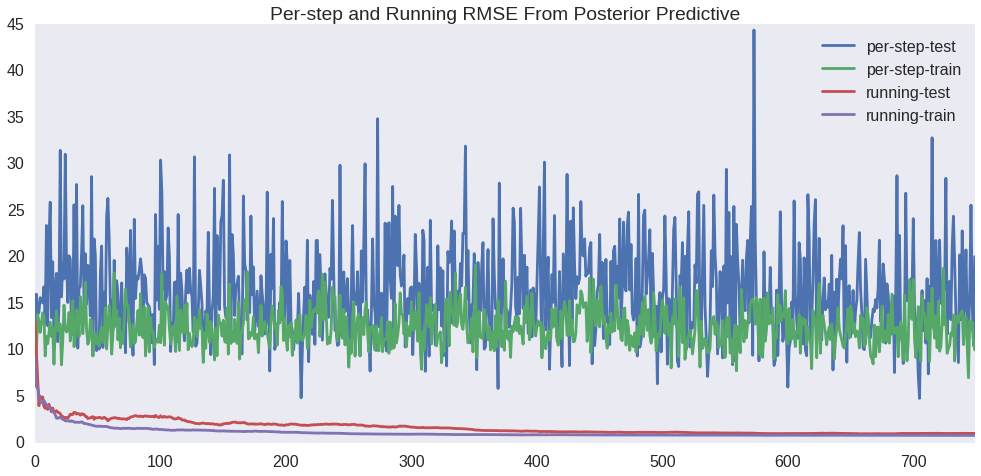

In [197]:
_,_,results_unpooled=unpooled_model.running_rmse(test, train, county_data,burn_in=5000)

In [198]:
results_unpooled.tail(3)

,per-step-test,per-step-train,running-test,running-train
747,14.850666,12.968655,0.992773,0.771092
748,10.439846,10.874049,0.990719,0.772236
749,20.002211,9.972424,0.982994,0.771789


$$\\[5pt]$$
Model based on partly-pooled measurements
----------------------

-------

This is the hierarchical model, which creates group parameters that consider the countys not as completely different but as having an underlying similarity. These distributions are subsequently used to influence the distribution of each county's $\alpha$ and 
$\beta$.


The code of the model is given below.

In [13]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    A Model based on the partly-pooled data
'''


#defines the class for the Modeling
class ModelHierarchical(BaseModel):
    """ A ModelHierarchical class 
         :param np.ndarray data: The  data to use for learning the model. 
         :param np.ndarray aux_data: The  data to use for learning the model. 
         
         
    """


    
    def __init__(self, data,aux_data):        
    
        logging.info('building the  model....') 
        super(ModelHierarchical,self).__init__( data ) 
        
        
        self.aux_data = aux_data # the data contain name of the county and its id
        self.county_idx = aux_data['county_idx'].values
        
        
        alpha_value_init = np.mean(data.loc[data['floor'] == 0,'log_radon'].values)
        beta_value_init = np.mean(data.loc[data['floor'] == 1,'log_radon'].values)
        beta_value_init -= alpha_value_init
            
        
        # alpha and beta priors
        self.mu_alpha = pm.Normal("mu_alpha", 
                        mu=0., 
                        #tau=100,                         
                        tau=100**-1, # tau is singma^{-1}
                        value=alpha_value_init) 
        self.sigma_alpha = pm.Uniform('sigma_alpha', lower=0, upper=100)
            
        self.mu_beta = pm.Normal("mu_beta", 
                        mu=0., 
                        #tau=100, 
                        tau=100**-1,
                        value=beta_value_init) 
        
        self.sigma_beta = pm.Uniform('sigma_beta', lower=0, upper=100)
        
        
         
        self.alpha = pm.Normal("alpha", 
                        mu=self.mu_alpha, 
                        tau=self.sigma_alpha, 
                        size=len(self.aux_data),
                        value=np.zeros(len(self.aux_data))
                        )
        
        self.beta = pm.Normal("beta", 
                        mu=self.mu_beta, 
                        tau=self.sigma_beta, 
                        size=len(self.aux_data),
                        value=np.zeros(len(self.aux_data))
                        )                
        #  error prior
        self.eps = pm.Uniform('eps', lower=0, upper=100)
        
        # new dataframe
        self.data_update = self.data.copy()
        self.data_update=pd.merge(self.data_update, aux_data, left_on='county', right_on='county_names', how='left')
        self.data_update = self.data_update.drop('county_names', 1)
                
        
        
        
        # log of the radon level
        # Linear model of the log of the radon level        
        @pm.deterministic
        def log_radon(alpha=self.alpha, 
            beta=self.beta,
            county_idx = self.data_update["county_idx"].values,
            floor=self.data_update["floor"].values): 
            return alpha[county_idx]+ beta[county_idx]*floor 
            
                

        # what we observed is           
        self.radon_observed = pm.Normal('radon_observed', 
                          mu=log_radon, 
                          tau=self.eps,
                          value=self.data["log_radon"].values,         
                          observed=True)
        
        # our model collects all definitions in self.model        
        self.model = pm.MCMC([
                self.mu_alpha,self.sigma_alpha,self.mu_beta,self.sigma_beta,
                self.alpha, self.beta,self.eps,log_radon,
                self.radon_observed
            ])
        logging.info('done building the  model')




def _prepare_trace(self):
    ''' prepare a dataframe with traces of the alpha,beta and eps parameters of 
    our model
    '''
    self.traces={                                
                                'mu_alpha': self.mu_alpha.trace(), 
                                'sigma_alpha': self.sigma_alpha.trace(), 
                                'mu_beta': self.mu_beta.trace(),
                                'sigma_beta': self.sigma_beta.trace(),
                                'eps': self.eps.trace(),
                               }
    
    alphas=self.model.trace('alpha').gettrace()
    betas=self.model.trace('beta').gettrace()
    
    
    for indx in range(self.alpha.value.shape[0]):
        self.traces.update({"alpha_%d"%indx:alphas[:,indx]})
    
    for indx in range(self.beta.value.shape[0]):
        self.traces.update({"beta_%d"%indx:betas[:,indx]})
    
    self.traces = pd.DataFrame(self.traces)
    
    return  self.traces   


# Update our Model
ModelHierarchical.prepare_trace = _prepare_trace
    
hierarchical_model= ModelHierarchical(train,county_data)
hierarchical_model.model.sample(20000, 5000, 20)


INFO:root:building the  model....
INFO:root:done building the  model


 [-----------------100%-----------------] 20000 of 20000 complete in 8.8 sec

In [40]:
# test of the shapes: variables and their traces
print hierarchical_model.model.trace('alpha').gettrace().shape
print hierarchical_model.mu_alpha.trace().shape
print hierarchical_model.alpha.value.shape

(750, 85)
(750,)
(85,)


The `predict` and `Running-RMSE` methods  are defined accordingly.

In [14]:
def _predict(self,test_data,aux_data,alphas=None,betas=None,epses=None):
    ''' predicts results on the test data '''

    test_data_copy = test_data.copy()
    test_data_copy=pd.merge(test_data_copy, aux_data, left_on='county', right_on='county_names', how='left')
    test_data_copy = test_data_copy.drop('county_names', 1)
    
    if (alphas is None): alphas = self.alpha.value
    if (betas is None): betas = self.beta.value
    if (epses is None): epses = self.eps.value
    
    
    test_data_copy['log_radon_predict'] = test_data_copy.apply(
        lambda x: np.random.normal(
                alphas[x['county_idx']] +
                betas[x['county_idx']] * x['floor'],
                epses
            ),
         axis=1
        )
              
    self.predicted = test_data_copy['log_radon_predict'].values
    return self.predicted



# Update the interface of our model
ModelHierarchical.predict = _predict    


In [15]:
hierarchical_model.predict(train,county_data)
print "RMSE on train data: ", hierarchical_model.rmse(train["log_radon"].values)

hierarchical_model.predict(test,county_data)
print "RMSE on test data: ", hierarchical_model.rmse(test["log_radon"].values)

RMSE on train data:  1.99558981897
RMSE on test data:  2.32077127218


In [16]:
def _running_rmse(self, test_data, train_data, aux_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    
    traces = self.prepare_trace()
    burn_in = burn_in if len(traces) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}

    R_train = np.zeros(len(train_data))
    R_test = np.zeros(len(test_data))

    for cnt in range(burn_in,len(traces)):
        
        alphas=[]
        betas=[]
        
        for indx in range(self.alpha.value.shape[0]):
            alphas +=[traces.loc[cnt,"alpha_%d"%indx]]
        for indx in range(self.beta.value.shape[0]):
            betas +=[traces.loc[cnt,"beta_%d"%indx]]
        
        eps = traces.loc[cnt,"eps"]
        predicted_train = self.predict(train_data,aux_data,alphas,betas,eps)
        predicted_test = self.predict(test_data,aux_data,alphas,betas,eps)
        R_train += predicted_train
        R_test += predicted_test        
        running_R_train = R_train / (cnt + 1)
        running_R_test = R_test / (cnt + 1)
        
        results['per-step-train'].append(rmse(train_data["log_radon"].values, predicted_train))
        results['running-train'].append(rmse(train_data["log_radon"].values, running_R_train))
        results['per-step-test'].append(rmse(test_data["log_radon"].values, predicted_test))
        results['running-test'].append(rmse(test_data["log_radon"].values, running_R_test))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')

    # Return the final predictions, and the RMSE calculations
    return running_R_train,running_R_test, results


# Update the interface of ModelPooled
ModelHierarchical.running_rmse = _running_rmse

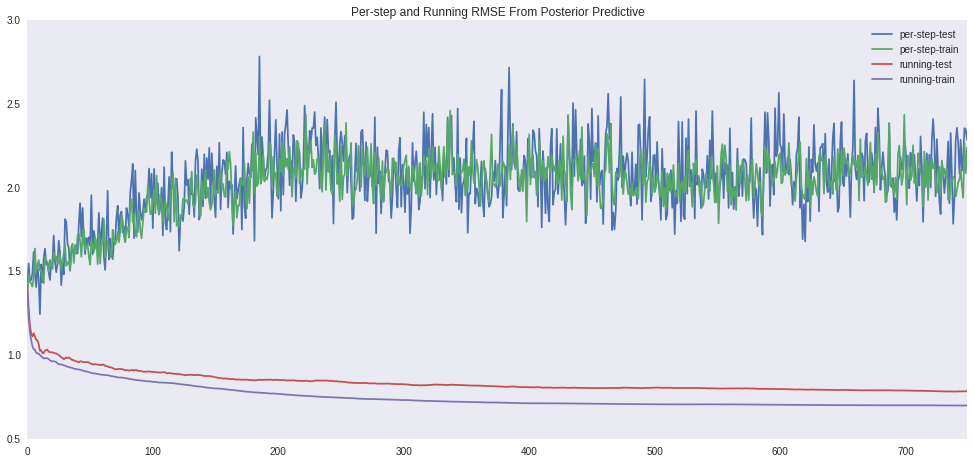

In [17]:
_,_,results_hierarchical=hierarchical_model.running_rmse(test, train,county_data, burn_in=5000)

In [18]:
results_hierarchical.tail(3)

,per-step-test,per-step-train,running-test,running-train
747,2.356270,2.266139,0.783504,0.698728
748,2.348432,2.087505,0.784100,0.698816
749,2.287256,2.240132,0.784028,0.698708


As can be seen above the hierarchical model performs better than the non-hierarchical models in predicting the radon values. Following this, we'll plot some examples of county's models showing the actual radon measurements, the hierarchial predictions and the non-hierarchical predictions. 


$$\\[5pt]$$
Visualization
-----------------

---------------------


We define several plot functions to demonstrate the predictions.

$$\\[5pt]$$
### Plotting of the fitted parameters

---------------------------------------

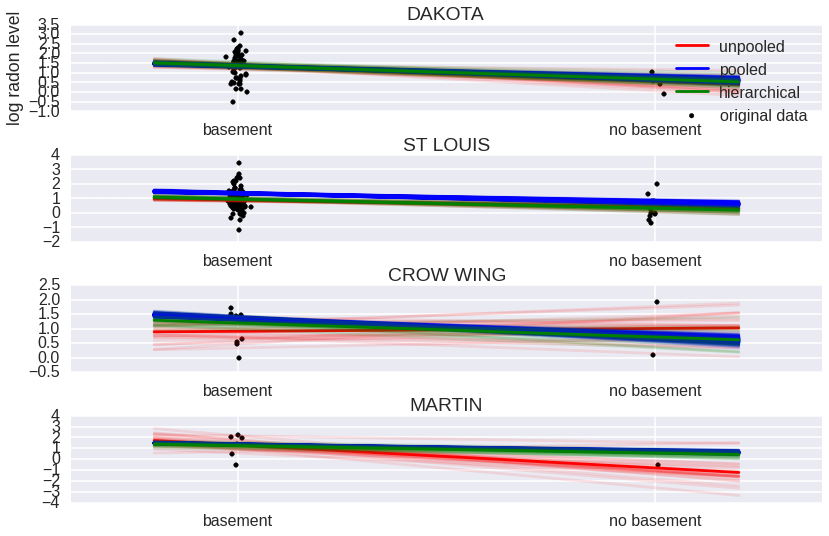

In [57]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    plotting support for discussed models
'''


def plot_predictions(models,data,aux_data,selection):
    ''' plots predictions '''
    sns.set_context("poster")
    plt.figure(figsize=(15,8))
    
    fig = plt.figure(figsize=(12,8))
    
    data_copy = data.copy()
    data_copy=pd.merge(data_copy, aux_data, left_on='county', right_on='county_names', how='left')
    data_copy = data_copy.drop('county_names', 1)
    
    xvals = np.linspace(-0.2, 1.2) # range on the x-axis
    for i, c in enumerate(selection):
        c_data = data_copy.ix[data_copy["county"] == c]        
        c_data = c_data.reset_index(drop = True)        
        idx = list(c_data['county_idx'])[0] # contains county_idx for the selected county
        fig.add_subplot(str(len(selection))+'1'+str(i+1))        
        for model in models:
            if type(model) == ModelPooled:                
                traces = model.prepare_trace()
                alpha_trace=traces["alpha"].values[500::10]
                beta_trace=traces["beta"].values[500::10]                
                for j in range(len(alpha_trace)):
                    plot(xvals, alpha_trace[j] + beta_trace[j] * xvals, 'b', alpha=.1)
                plot(xvals, alpha_trace.mean() + beta_trace.mean() * xvals, 'b',label="pooled")

            elif type(model) == ModelUnPooled:
                traces = model.prepare_trace()
                alpha_trace=traces["alpha_%d"%idx].values[500::10]
                beta_trace=traces["beta_%d"%idx].values[500::10]
                #alpha_trace=traces["alpha_%d"%idx].values[50000::300]
                #beta_trace=traces["beta_%d"%idx].values[50000::300]
                for j in range(len(alpha_trace)):
                    plot(xvals, alpha_trace[j] + beta_trace[j] * xvals, 'r', alpha=.1)
                plot(xvals, alpha_trace.mean() + beta_trace.mean() * xvals, 'r',label="unpooled")                
            elif type(model) == ModelHierarchical:
                traces = model.prepare_trace()
                alpha_trace=traces["alpha_%d"%idx].values[500::10]
                beta_trace=traces["beta_%d"%idx].values[500::10]
                for j in range(len(alpha_trace)):
                    plot(xvals, alpha_trace[j] + beta_trace[j] * xvals, 'g', alpha=.1)
                plot(xvals, alpha_trace.mean() + beta_trace.mean() * xvals, 'g',label="hierarchical")


        scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon, 
                   alpha=1, color='k', marker='.', s=80, label='original data')
        
        axis = plt.gca()
        axis.set_xticks([0,1])
        axis.set_xticklabels(['basement', 'no basement'])
        #axis.set_ylim(-0.1, 0.1)
        axis.set_title(c)        
        if not i%100:
            axis.legend()
            axis.set_ylabel('log radon level')


#print test
plot_predictions([unpooled_model,pooled_model,hierarchical_model],train,county_data,[
        'DAKOTA','ST LOUIS','CROW WING','MARTIN'
    ])





$$\\[5pt]$$
Shrinkage
----------------------

-------


>Shrinkage describes the process by which our estimates are "pulled" towards the group-mean as a result of the common group distribution -- county-coefficients very far away from the group mean have very low probability under the normality assumption, moving them closer to the group mean gives them higher probability.


In the non-hierachical model every county is allowed to differ completely from the others by just using each county's data, resulting in a model more prone to outliers (as shown above). 

$$\\[5pt]$$
### Shrinkage plot

-----------------------


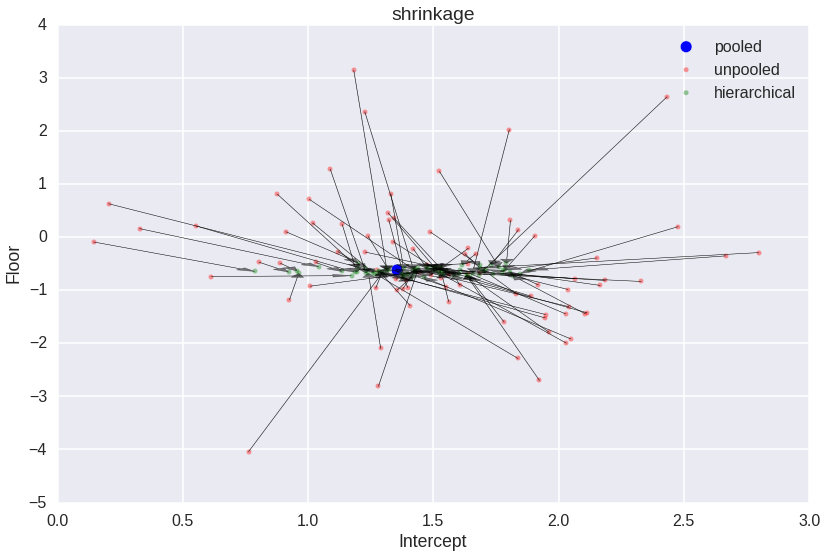

In [45]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    Plotting of the shrinkage effect
'''

def plot_shrinkage(models,data,aux_data):
    ''' plots the shrinkage effect '''
    
    sns.set_context("poster")
    plt.figure(figsize=(15,8))    
    fig = plt.figure(figsize=(12,8))

    data_copy = data.copy()
    data_copy=pd.merge(data_copy, aux_data, left_on='county', right_on='county_names', how='left')
    data_copy = data_copy.drop('county_names', 1)
    alpha_trace_all_unpooled = []
    beta_trace_all_unpooled = [] 
    alpha_trace_all_hierarchical = []
    beta_trace_all_hierarchical = [] 
    for model in models:
            if type(model) == ModelPooled:                
                traces = model.prepare_trace()
                alpha_trace=traces["alpha"].values[500::10]
                beta_trace=traces["beta"].values[500::10]                   
                scatter(alpha_trace.mean(), beta_trace.mean(),  c='blue', s=136, alpha=1, label ="pooled")
            elif type(model) == ModelUnPooled:
                traces = model.prepare_trace()
                for idx in aux_data['county_idx'].values:
                    alpha_trace=traces["alpha_%d"%idx].values[500::10]
                    beta_trace=traces["beta_%d"%idx].values[500::10]
                    
                    alpha_trace_all_unpooled+=[alpha_trace.mean()]
                    beta_trace_all_unpooled+=[beta_trace.mean()]
                    if idx == len(aux_data['county_idx'].values) -1:
#                        scatter(alpha_trace_all_unpooled,beta_trace_all_unpooled, c='red', s=26, alpha=0.4, label = 'unpooled')
                        scatter(alpha_trace.mean(),beta_trace.mean(), c='red', s=26, alpha=0.4, label = 'unpooled')
                    else:
#                        scatter(alpha_trace_all_unpooled,beta_trace_all_unpooled, c='red', s=26, alpha=0.4)
                        scatter(alpha_trace.mean(),beta_trace.mean(), c='red', s=26, alpha=0.4)

            elif type(model) == ModelHierarchical:
                traces = model.prepare_trace()

                for idx in aux_data['county_idx'].values:
                    alpha_trace=traces["alpha_%d"%idx].values[500::10]
                    beta_trace=traces["beta_%d"%idx].values[500::10]
                    alpha_trace_all_hierarchical+=[alpha_trace.mean(axis=0)]
                    beta_trace_all_hierarchical+=[beta_trace.mean(axis=0)]
                    if idx == len(aux_data['county_idx'].values) -1:
#                        scatter(alpha_trace_all_hierarchical,beta_trace_all_hierarchical, c='green', s=26, alpha=0.4, label = 'hierarchical')          
                        scatter(alpha_trace.mean(),beta_trace.mean(), c='green', s=26, alpha=0.4, label = 'hierarchical')          
                    else:
#                        scatter(alpha_trace_all_hierarchical,beta_trace_all_hierarchical, c='green', s=26, alpha=0.4)
                        scatter(alpha_trace.mean(),beta_trace.mean(), c='green', s=26, alpha=0.4)

    for i in range(len(aux_data['county_idx'].values)):  
        arrow(alpha_trace_all_unpooled[i], beta_trace_all_unpooled[i], 
              alpha_trace_all_hierarchical[i] - alpha_trace_all_unpooled[i], 
              beta_trace_all_hierarchical[i] - beta_trace_all_unpooled[i], 
             fc="k", ec="k", length_includes_head=True, alpha=0.5, head_width=.05)

                    
    axis = plt.gca()
    axis.set_title("shrinkage")        
    axis.legend()
    axis.set_xlabel('Intercept')
    axis.set_ylabel('Floor')
                


plot_shrinkage([pooled_model,unpooled_model,hierarchical_model],test,county_data)                


To show the effect of shrinkage on a single coefficient-pair (alpha and beta) we connect the red and green points belonging to the same county by an arrow. Some non-hierarchical posteriors are so far out that we couldn't display them in this plot (it makes the axes too wide).

$$\\[5pt]$$
#### Plotting of radon levels of different counties. 


---------------------

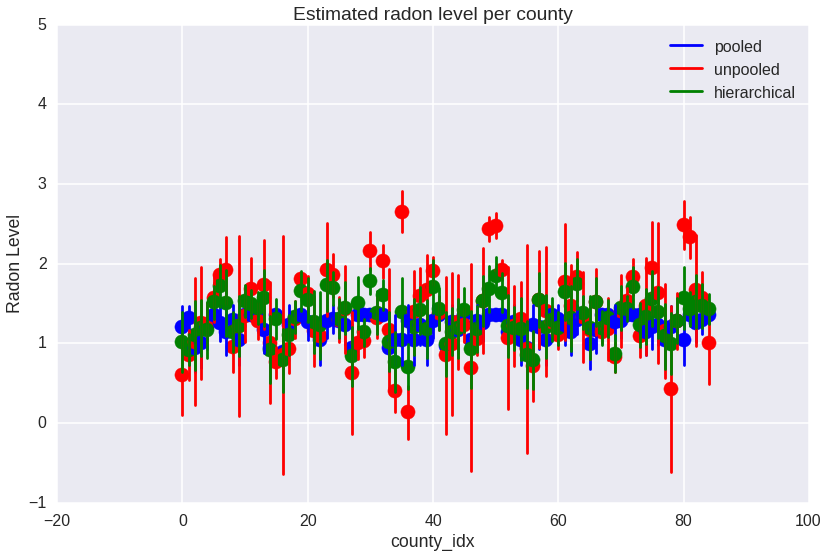

In [121]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    plotting support for discussed models
'''


def plot_predicted_radon_level(models,data,aux_data,selection):
    ''' plots predictions '''
    sns.set_context("poster")
    plt.figure(figsize=(15,8))
    
    fig = plt.figure(figsize=(12,8))
    
    data_copy = data.copy()
    data_copy=pd.merge(data_copy, aux_data, left_on='county', right_on='county_names', how='left')
    data_copy = data_copy.drop('county_names', 1)
    
    fig.add_subplot('110')    
    for i, c in enumerate(selection):
        c_data = data_copy.ix[data_copy["county"] == c]        
        c_data = c_data.reset_index(drop = True)        
        idx = list(c_data['county_idx'])[0] # contains county_idx for the selected county
        floors =  c_data['floor'].values
            
        for model in models:
            if type(model) == ModelPooled:                
                traces = model.prepare_trace()
                alpha_trace=traces["alpha"].values[500::10]
                beta_trace=traces["beta"].values[500::10]  
                estimated_radon_level = []
                for j in range(len(alpha_trace)):
                    estimated_radon_level += (alpha_trace[j] + beta_trace[j] * floors).tolist()
                    
                statistics= pd.DataFrame(estimated_radon_level,columns=['radon_level']).describe() 
                std = statistics['radon_level']['std']
                mean = statistics['radon_level']['mean']
                if (i==0): plot([idx,idx],[mean-std,mean+std],'b-',label="pooled")
                else : plot([idx,idx],[mean-std,mean+std],'b-')
                scatter([idx],[mean],alpha=1, color='b', marker='.', s=800)
            
            elif type(model) == ModelUnPooled:
                traces = model.prepare_trace()
                alpha_trace=traces["alpha_%d"%idx].values[500::10]
                beta_trace=traces["beta_%d"%idx].values[500::10] 
                estimated_radon_level = []
                for j in range(len(alpha_trace)):
                    estimated_radon_level += (alpha_trace[j] + beta_trace[j] * floors).tolist()
                    
                statistics= pd.DataFrame(estimated_radon_level,columns=['radon_level']).describe() 
                std = statistics['radon_level']['std']
                mean = statistics['radon_level']['mean']
                if (i==0): plot([idx,idx],[mean-std,mean+std],'r-',label="unpooled")
                else : plot([idx,idx],[mean-std,mean+std],'r-')
                scatter([idx],[mean],alpha=1, color='r', marker='.', s=800)
            elif type(model) == ModelHierarchical:
                traces = model.prepare_trace()
                alpha_trace=traces["alpha_%d"%idx].values[500::10]
                beta_trace=traces["beta_%d"%idx].values[500::10] 
                estimated_radon_level = []
                for j in range(len(alpha_trace)):
                    estimated_radon_level += (alpha_trace[j] + beta_trace[j] * floors).tolist()
                    
                statistics= pd.DataFrame(estimated_radon_level,columns=['radon_level']).describe() 
                std = statistics['radon_level']['std']
                mean = statistics['radon_level']['mean']
                if (i==0): plot([idx,idx],[mean-std,mean+std],'g-',label="hierarchical")
                else : plot([idx,idx],[mean-std,mean+std],'g-')
                scatter([idx],[mean],alpha=1, color='g', marker='.', s=800)     
                    
    axis = plt.gca()
    axis.set_title("Estimated radon level per county")        
    axis.legend()
    axis.set_xlabel('county_idx')
    axis.set_ylabel('Radon Level') 
    plt.ylim([-1,5])
 
    
plot_predicted_radon_level([pooled_model,unpooled_model,hierarchical_model],
                           train,county_data,
                           county_data['county_names'].values.tolist()[0:])


$$\\[5pt]$$
Goodness of the Fit (GoF)
------------------------------

---------------------


The goodness of Fit (GOF) of a statistical model describes
how well it fits into a set of observations. GOF indices sum-
marize the discrepancy between the observed values and
the values expected under a statistical model. GOF statis-
tics are GOF indices with known sampling distributions,
usually obtained using asymptotic methods, that are used
in statistical hypothesis testing.

The PyMC proposes a list of the GoF indices:

* The Geweke statisics is a time-series approach that compares the mean and variance of segments from the beginning and end of a single chain.
* 95% CI on  parameters of the models 
* Gelman-Rubin statistics
* Discrepency statistics


$$\\[5pt]$$
###The Geweke statisics

---------------------

The geweke statistics is defined as follows

$$Z_n=\frac{\bar{\theta}_A-\bar{\theta}_B}{\sqrt{\frac{1}{n_A}\hat{S_{\theta}^A}(0)+\frac{1}{n_B}\hat{S_{\theta}^B}(0)}},$$


where A is the early interval and B the late interval. If the Z-scores (theoretically distributed as standard normal variates) of these two segments are similar, it can provide evidence for convergence. PyMC calculates Z-scores of the difference between various initial segments along the chain, and the last 50% of the remaining chain. If the chain has converged, the majority of points should fall within 2 standard deviations of zero. Here is the geweke statistics for the `PooledModel`.

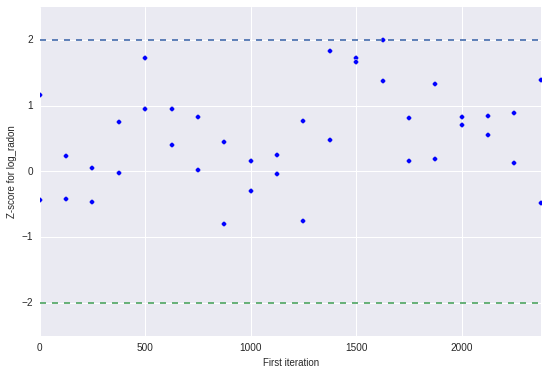

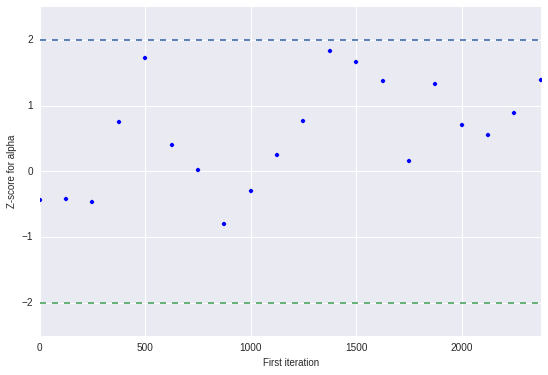

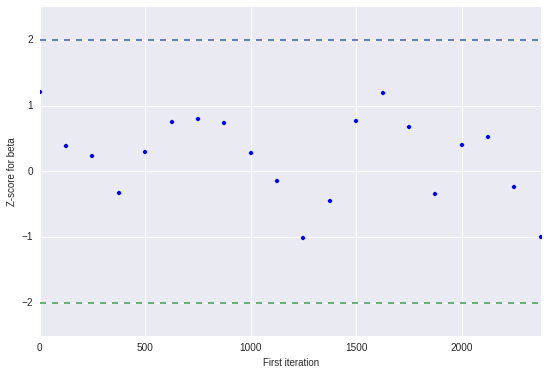

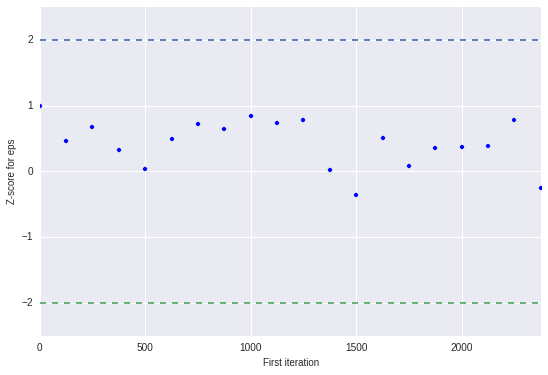

In [19]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    Geweke statistics for the pooled model.
'''
geweke_pooled=pm.geweke(pooled_model.model)
pm.Matplot.geweke_plot(geweke_pooled,path='plots/pooled_geweke_')

We can also calculate the Geweke statistics for two other models: `UnPooledModel` and `HierarchicalModel` (we will plot only statistics build on the `HierarchicalModel`).

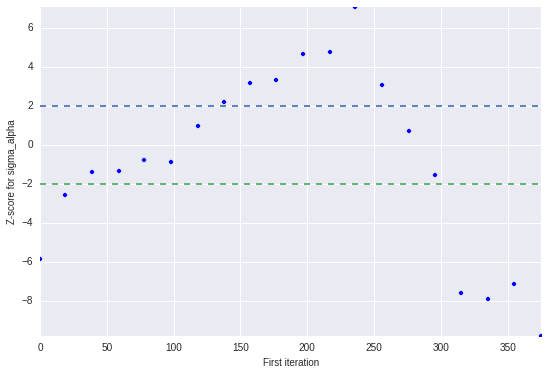

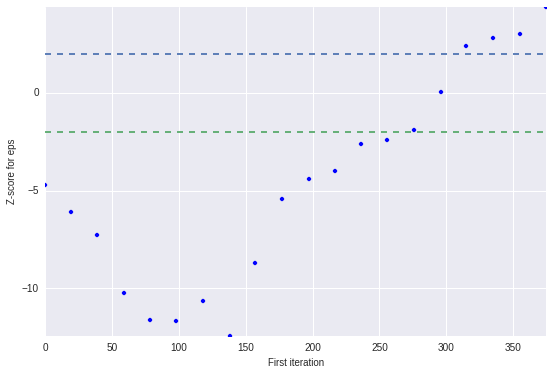

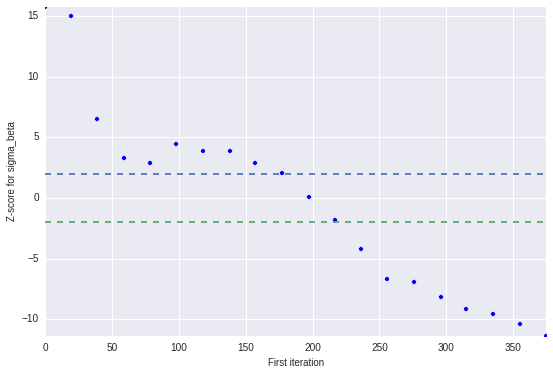

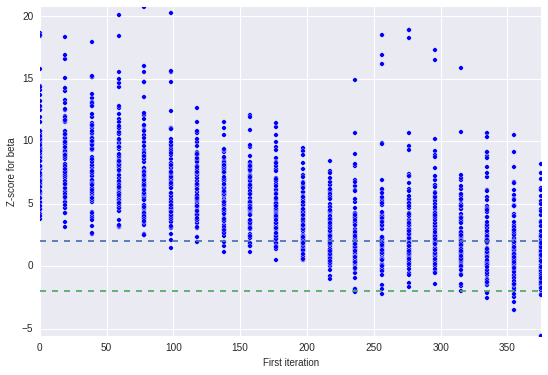

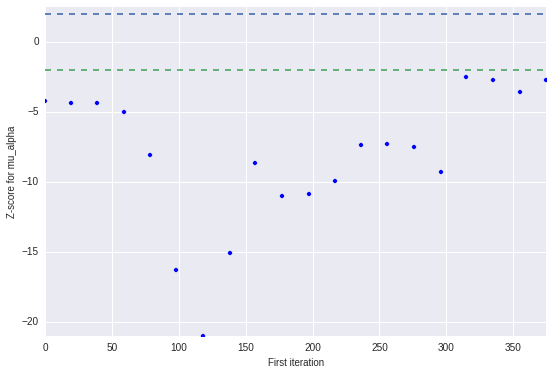

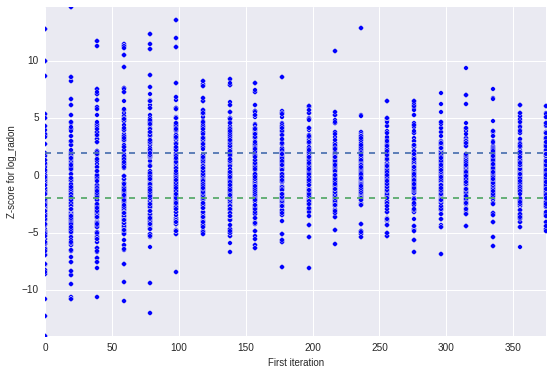

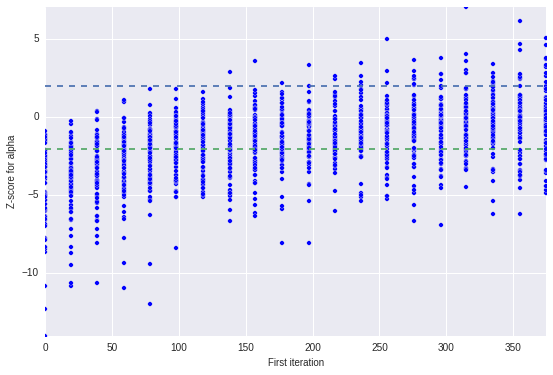

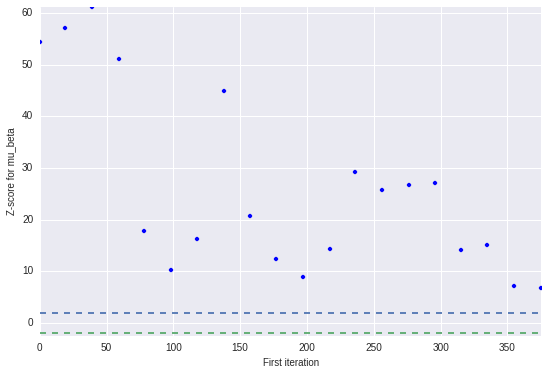

In [27]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    Geweke statistics for the hierarchical model.
'''
geweke_hierarchical=pm.geweke(hierarchical_model.model)
pm.Matplot.geweke_plot(geweke_hierarchical,path='plots/hierarchical_geweke_')

As expected, there are several alphas and betas with larger (smaller) z-scores than
$+2\sigma(-2\sigma)$. They correspond to counties with not enough data points to be good fitted. The betas z-scores show even the worser convergenge than alphas.

$$\\[5pt]$$
### 95% CI on parameters of the models  and  Gelman-Rubin diagnostic

----------------

Another diagnostic provided by PyMC is the **Gelman-Rubin statistics**. This diagnostic uses multiple chains to check for lack of convergence, and is based on the notion that if multiple chains have converged, by definition they should appear very similar to one another; if not, one or more of the chains has failed to converge.

The Gelman-Rubin diagnostic uses an analysis of variance approach to assessing convergence. That is, it calculates both the between-chain varaince (B) and within-chain varaince (W), and assesses whether they are different enough to worry about convergence. Assuming m chains, each of length n, quantities are calculated and merged in the 
estimated covariance matrix V:


\begin{equation}
\hat{V} = \frac{n-1}{n}W + \frac{1}{n}B,
\end{equation}

 Then, one needs to define some scalar metric for the distance between the covariance matrices $\hat{V},W$. The authors propose 

\begin{equation}
\hat{R} = \max_a \frac{a^T\hat{V}a}{a^TWa} = \frac{n-1}{n} + \left(\frac{m+1}{m}\right)\lambda_1,
\end{equation}

where m is  is the chain length. The equality contain $\lambda_1$ being the largest positive eigenvalue of $W^{−1}\hat{V}/n$.
This $\hat{R}$ is called the potential scale reduction, since it is an estimate of the potential reduction in the scale of the model parameters as the number of simulations tends to infinity. In practice, we look for values of $\hat{R}$ close to one (say, less than 1.1) to be confident that a particular estimand has converged.

In practice, we need to run MCMC chains several times in order to calculate the
**Gelman-Rubin** statistics. Lets's try to test `PooledModel` and `HierarchicalModel`.
The **PyMC** function `summary_plot` plots not only **Gelman-Rubin** statistics but also
the 95% CI on the parameters.

 [-----------------100%-----------------] 20000 of 20000 complete in 9.2 sec

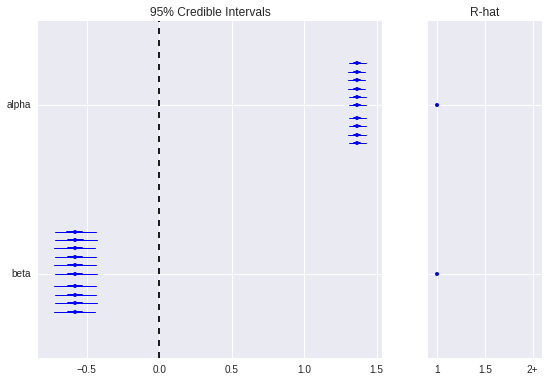

In [31]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    Gelman-Rubin statistics and 95% CI for the pooled/hierarchical models.
'''

# How many different MCMC chains do we need for Gelman-Rubin statistics
n_traces = 3

for i in range(n_traces):    
    pooled_model.model.sample(100000, 5000, 20)
    hierarchical_model.model.sample(20000, 5000, 20)
    


# create plots 
pm.Matplot.summary_plot([pooled_model.alpha,pooled_model.beta],path='plots/pooled_gr_',rhat=True)

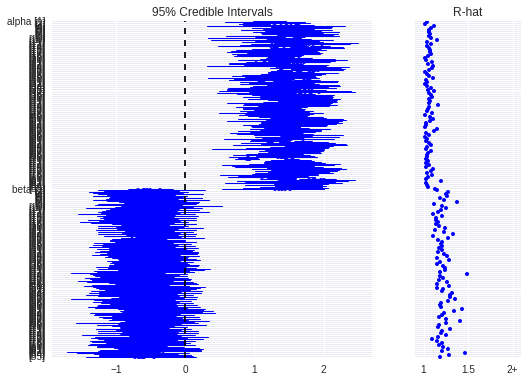

In [32]:
pm.Matplot.summary_plot([hierarchical_model.alpha,hierarchical_model.beta],path='plots/hierarchical_gr_',rhat=True)

In [30]:
# unpooled_model skipped from consideration
#from pymc import Matplot, gelman_rubin
#unpooled_variables=map(lambda x: unpooled_model.alphas["alpha_%d"%x],county_data['county_idx'].values.tolist()[0:])
#unpooled_variables+=map(lambda x: unpooled_model.betas["beta_%d"%x],county_data['county_idx'].values.tolist()[0:])
#Matplot.summary_plot(unpooled_variables,path='plots/',rhat=True)



Rhat values obtained from  the plots before, show the convergence to 1.0 and 1.2 for `Poolded` and `Hierarchical` models correspondingly.

$$\\[5pt]$$
### 95% CI on parameters of the models  and  Gelman-Rubin diagnostic

----------------


One can use the simulated data, the posterior predictive values, to make a discrepancy plot. The discrepancy calculates the difference between data/simulation tot he expected values from the model. A discrepancy plot plots the simulated discrepancy against the observed discrepancy. These should bunch around the 45 degree line.

The discrepancy is defined using the the Freeman-Tukey statistic:

$$D(x|\theta) = \sum_j (\sqrt{x_j}-\sqrt{e_j})^2,$$

where  the $x_j$ are data and $e_j$ are the corresponding expected values, based on the model. The average difference between the simulated and observed discrepancy ought to be zero. The Bayesian p-value is the proportion of simulated discrepancies that are larger than their corresponding observed discrepancies:

$$\begin{split}p = Pr[ D(x_{\text{sim}}|\theta) > D(x_{\text{obs}}|\theta) ]\end{split}.$$

If p is very large or very small the model is not consistent with the data. This is pointing to lack of fit.
We try to calculate the Discrepancy statistics for `Pooled` Model first. 
To do this, we need to extend the interface of the model, introducing the methods to return expected values of the `log_radon` and to
perform simulations.


User defined Freeman-Tukey statistics: 
25942.7449905
26311.8992629
29211.6401619
30017.0258718
Bayesian p-value: p=0.971
PyMC defined Freeman-Tukey statistics: 
[ 25942.74499048  29211.64016191] [ 26311.89926291  30017.02587182]
Plotting D-gof


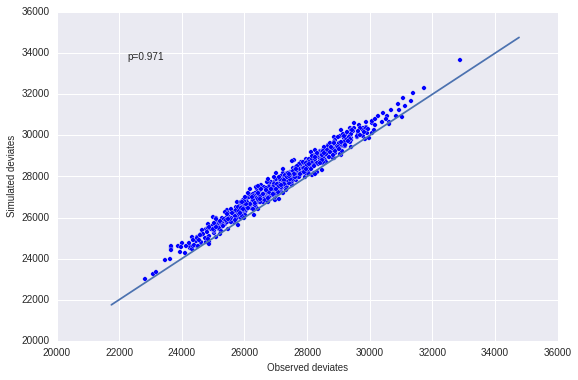

In [115]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
     get_expected() and make_simulations() methods for the pooled model.
'''

def _get_expected(self,burn_in):
    ''' returns the traces of the expectations 
        (which are deterministic quantities in PyMC)
    '''
    burn_in = burn_in if len(self.traces) >= burn_in else 0
    self.expected={}
    for var in list(self.model.deterministics):
        # the reason of the these lines see below
        shape=self.model.trace(str(var))[:].shape
        b=np.array(self.model.trace(str(var))[-1].tolist()*(len(self.traces)-burn_in))        
        c= b.reshape(len(self.traces)-burn_in,shape[1])
        
        
        self.expected.update(
                # version 1
                #{str(var):self.model.trace(str(var))[burn_in:]}
            
                # version 2
                # instead to use all traces of the deterministic variables,
                # we are going to use the value from the last MCMC point
                # plus the noise (noise is Gaussian with large sigma)
                {str(var):c + np.random.normal(0,100,(len(self.traces)-burn_in,shape[1])) 
                }
        )
    return    self.expected 


def _make_simulations(self, test_data, burn_in=0):
    """ returns the simulation of the observed quantity
    """
    
    traces = self.prepare_trace()
    burn_in = burn_in if len(traces) >= burn_in else 0
    
    simulations=[]
    for cnt in range(burn_in,len(traces)):
        alpha = traces.loc[cnt,"alpha"]
        beta = traces.loc[cnt,"beta"]
        eps = traces.loc[cnt,"eps"]        
        simulations += [self.predict(test_data,alpha,beta,eps)]
        
        
    return np.array(simulations)    
    
        
# Update the interface of the ModelPooled        
ModelPooled.get_expected = _get_expected
ModelPooled.make_simulations = _make_simulations

expected=pooled_model.get_expected(burn_in=4000)['log_radon']        
simulated=pooled_model.make_simulations(train, burn_in=4000)

# print the calucation of the first two elements of  Freeman-Tukey statistic 
#func_regularization=np.exp
#func_regularization=np.abs
func_regularization = np.vectorize(lambda x:  x if x>0 else 0.)

# transform from log levels of the radon to normal levels of the radon
expected =  func_regularization(expected)
simulated = func_regularization(simulated)
data = func_regularization(train["log_radon"].values)


print "User defined Freeman-Tukey statistics: "
print sum((np.sqrt(data) - np.sqrt(expected[0]))**2)
print sum((np.sqrt(simulated[0]) - np.sqrt(expected[0]))**2)
print sum((np.sqrt(data) - np.sqrt(expected[1]))**2)
print sum((np.sqrt(simulated[1]) - np.sqrt(expected[1]))**2)


D = pm.discrepancy(data,simulated, expected)
print "PyMC defined Freeman-Tukey statistics: "
print D[0][0:2],D[1][0:2]
pm.Matplot.discrepancy_plot(D, name='D', report_p=True,path='plots/pooled_discrepancy_')

User defined Freeman-Tukey statistics: 
28831.5719335
30416.0211203
25476.3089558
26693.4656682
Bayesian p-value: p=0.987
PyMC defined Freeman-Tukey statistics: 
[ 28831.57193353  25476.30895579] [ 30416.02112029  26693.46566816]
Plotting D-gof


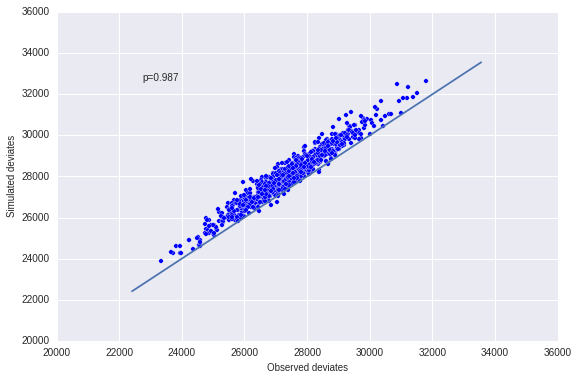

In [108]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
     get_expected() and make_simulations() methods for the hierarchical model.
'''

def _get_expected(self,burn_in):
    ''' returns the traces of the expectations 
        (which are deterministic quantities in PyMC)
    '''
    burn_in = burn_in if len(self.traces) >= burn_in else 0
    self.expected={}
    for var in list(self.model.deterministics):
        # the reason of theselines see below
        shape=self.model.trace(str(var))[:].shape
        b=np.array(self.model.trace(str(var))[-1].tolist()*(len(self.traces)-burn_in))        
        c= b.reshape(len(self.traces)-burn_in,shape[1])
        
        
        self.expected.update(
                # version 1
                #{str(var):self.model.trace(str(var))[burn_in:]}
            
                # version 2
                # instead to use all traces of the deterministic variables,
                # we are going to use the value from the last MCMC point
                # plus the noise (noise is Gaussian with large sigma )
                {str(var):c + np.random.normal(0,100,(len(self.traces)-burn_in,shape[1])) 
                }
        )
    return    self.expected 



def _make_simulations(self, test_data,aux_data, burn_in=0):
    """ returns the simulation of the observed quantity
    """
    
    traces = self.prepare_trace()
    burn_in = burn_in if len(traces) >= burn_in else 0
    
    simulations=[]
    for cnt in range(burn_in,len(traces)):
        
        alphas=[]
        betas=[]
        
        for indx in range(self.alpha.value.shape[0]):
            alphas +=[traces.loc[cnt,"alpha_%d"%indx]]
        for indx in range(self.beta.value.shape[0]):
            betas +=[traces.loc[cnt,"beta_%d"%indx]]
        
        eps = traces.loc[cnt,"eps"]
        simulations += [self.predict(test_data,aux_data,alphas,betas,eps)]
        
        
    return np.array(simulations)    
    

# Update the interface of the ModelHierarchical        
ModelHierarchical.get_expected = _get_expected
ModelHierarchical.make_simulations = _make_simulations


expected=hierarchical_model.get_expected(burn_in=4000)['log_radon']        
simulated=hierarchical_model.make_simulations(train,county_data, burn_in=4000)

# print the calucation of the first two elements of  Freeman-Tukey statistic 
#func_regularization=np.exp
#func_regularization=np.abs
func_regularization = np.vectorize(lambda x:  x if x>0 else 0.)

# transform from log levels of the radon to normal levels of the radon
expected =  func_regularization(expected)
simulated = func_regularization(simulated)
data = func_regularization(train["log_radon"].values)


print "User defined Freeman-Tukey statistics: "
print sum((np.sqrt(data) - np.sqrt(expected[0]))**2)
print sum((np.sqrt(simulated[0]) - np.sqrt(expected[0]))**2)
print sum((np.sqrt(data) - np.sqrt(expected[1]))**2)
print sum((np.sqrt(simulated[1]) - np.sqrt(expected[1]))**2)


D = pm.discrepancy(data,simulated, expected)
print "PyMC defined Freeman-Tukey statistics: "
print D[0][0:2],D[1][0:2]
pm.Matplot.discrepancy_plot(D, name='D', report_p=True,path='plots/hierarchical_discrepancy_')

$$\\[5pt]$$

Optional matherial
--------------------------


------------------

We can extend our partly-pooled model (or hierarchical model)

$$radon_{i,c}=\alpha_c+\beta_c\times floor_{i,c}+\varepsilon_c, $$

to the model where $\alpha_c$ is modelled by another regression model with a county-level covariate. In the blog [[2]](#Blog2), Chris Fonnesbeck suggests to use
the uranium level $u_c$, which is thought to be related to radon levels:

$$\alpha_c = \gamma_0 + \gamma_1 u_c + \zeta_c,$$

where 

$$\zeta_c \sim N(0, \sigma_{\alpha}^2).$$

Such model is called a model with group-level predictors $(u_c)$.
Before we start writting our model, we need to scrape the needed data from 
Chris's repository, and make cleaning and grouping the obtained information.


$$\\[5pt]$$
### Getting and cleaning the data

-------------------------------------

Let's download Chris's data on uranium levels in different states and counties.



In [117]:
!mkdir data
!wget https://raw.githubusercontent.com/fonnesbeck/multilevel_modeling/master/data/cty.dat -O data/cty.dat
!wget https://raw.githubusercontent.com/fonnesbeck/multilevel_modeling/master/data/srrs2.dat -O data/srrs2.dat

mkdir: cannot create directory `data': File exists
--2015-08-10 15:03:17--  https://raw.githubusercontent.com/fonnesbeck/multilevel_modeling/master/data/cty.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.31.17.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.31.17.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143270 (140K) [text/plain]
Saving to: `data/cty.dat'

100%[======================================>] 143,270      556K/s   in 0.3s    

2015-08-10 15:03:18 (556 KB/s) - `data/cty.dat' saved [143270/143270]

--2015-08-10 15:03:18--  https://raw.githubusercontent.com/fonnesbeck/multilevel_modeling/master/data/srrs2.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.31.17.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.31.17.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650106 (1.6M) [text/plain]
Saving to: `data/sr

Now, let's combine them in one dataframe.
All needed steps were taken from the Chris's blog [[2]](#Blog2).

In [139]:
# get radon data and make a dataframe
srrs2 = pd.read_csv('data/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state=='MN']
srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips

# get urnaium data and make another dataframe 
cty = pd.read_csv('data/cty.dat')
cty_mn = cty[cty.st=='MN']
cty_mn['fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

# merge two dataframes in one 
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')

# add log values of the radon and uranium levels
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
srrs_mn['log_uranium'] = u = np.log(srrs_mn.Uppm)

# add county_code
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))

srrs_mn['county_code'] =county = srrs_mn.county.replace(county_lookup).values


# remove uninteresting columns
columns_of_interest=['county','log_radon','floor','log_uranium','county_code']
radon_data_extended=srrs_mn[columns_of_interest]
print radon_data_extended.head(6)
print radon_data_extended.tail(6)

# make an auxiliary dataframe: county_data
county_names = radon_data_extended.county.unique()
county_idx = radon_data_extended['county_code'].values
n_counties = len(radon_data_extended.county.unique())

county_data=pd.DataFrame({
    "county_names":county_names,
    "county_idx": radon_data_extended['county_code'].unique()      
    })

print county_data.head(6)
print county_data.tail(6)


   county  log_radon  floor  log_uranium  county_code
0  AITKIN   0.832909      1    -0.689048            0
1  AITKIN   0.832909      0    -0.689048            0
2  AITKIN   1.098612      0    -0.689048            0
3  AITKIN   0.095310      0    -0.689048            0
4   ANOKA   1.163151      0    -0.847313            1
5   ANOKA   0.955511      0    -0.847313            1
              county  log_radon  floor  log_uranium  county_code
921           WRIGHT   2.261763      0    -0.090024           83
922           WRIGHT   1.871802      0    -0.090024           83
923           WRIGHT   1.526056      0    -0.090024           83
924           WRIGHT   1.629241      0    -0.090024           83
925  YELLOW MEDICINE   1.335001      0     0.355287           84
926  YELLOW MEDICINE   1.098612      0     0.355287           84
   county_idx county_names
0           0       AITKIN
1           1        ANOKA
2           2       BECKER
3           3     BELTRAMI
4           4       BENTON
5    

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Now we define our `ExtendedHierarchical` model with uranium predictors.

In [174]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    A Model based on the partly-pooled data
'''


#defines the class for the Modeling
class ModelExtendedHierarchical(BaseModel):
    """ A ModelExtendedHierarchical class 
         :param np.ndarray data: The  data to use for learning the model. 
         :param np.ndarray aux_data: The  data to use for learning the model. 
         
         
    """


    
    def __init__(self, data,aux_data):        
    
        logging.info('building the  model....') 
        super(ModelExtendedHierarchical,self).__init__( data ) 
        
        
        self.aux_data = aux_data # the data contain name of the county and its id
        self.county_idx = aux_data['county_idx'].values
        
        
        alpha_value_init = np.mean(data.loc[data['floor'] == 0,'log_radon'].values)
        beta_value_init = np.mean(data.loc[data['floor'] == 1,'log_radon'].values)
        beta_value_init -= alpha_value_init
            
        # County uranium model for slope
        self.gamma_0 = pm.Normal('gamma_0', mu=0., tau=0.0001)
        self.gamma_1 = pm.Normal('gamma_1', mu=0., tau=0.0001)    
        
        # alpha and beta priors
        self.sigma_alpha = pm.Uniform('sigma_alpha', lower=0, upper=100)
            
        self.mu_beta = pm.Normal("mu_beta", 
                        mu=0., 
                        #tau=100, 
                        tau=100**-1,
                        value=beta_value_init) 
        
        self.sigma_beta = pm.Uniform('sigma_beta', lower=0, upper=100)
        
        
         
        self.beta = pm.Normal("beta", 
                        mu=self.mu_beta, 
                        tau=self.sigma_beta, 
                        size=len(self.aux_data),
                        value=np.zeros(len(self.aux_data))
                        )                
        #  error prior
        self.eps = pm.Uniform('eps', lower=0, upper=100)
        
        # new dataframe
        self.data_update = self.data.copy()
        self.data_update=pd.merge(self.data_update, aux_data, left_on='county', right_on='county_names', how='left')
        self.data_update = self.data_update.drop('county_names', 1)
        
        self.alpha_eps = pm.Normal("alpha_eps", 
                        mu=0, 
                        tau=self.sigma_alpha, 
                        size=len(self.aux_data),
                        value=np.zeros(len(self.aux_data))
                        )
        
        
        
        # log of the radon level
        # Linear model of the log of the radon level        
        @pm.deterministic
        def log_radon(
            alpha_eps=self.alpha_eps, 
            gamma0=self.gamma_0, 
            gamma1=self.gamma_1,
            uranium= self.data_update["log_uranium"].values,                          
            beta=self.beta,
            county_idx = self.data_update["county_idx"].values,
            floor=self.data_update["floor"].values): 
            return gamma0+gamma1*uranium+ alpha_eps[county_idx]+ beta[county_idx]*floor 

        # what we observed is           
        self.radon_observed = pm.Normal('radon_observed', 
                          mu=log_radon, 
                          tau=self.eps,
                          value=self.data["log_radon"].values,         
                          observed=True)
        
        # our model collects all definitions in self.model        
        self.model = pm.MCMC([
                self.gamma_0,self.gamma_1,self.alpha_eps,self.sigma_alpha,
                self.mu_beta,self.sigma_beta,
                self.beta,self.eps,log_radon,
                self.radon_observed
            ])
        logging.info('done building the  model')




def _prepare_trace(self):
    ''' prepare a dataframe with traces of the alpha,beta and eps parameters of 
    our model
    '''
    self.traces={                                
                                
                                'sigma_alpha': self.sigma_alpha.trace(), 
                                'mu_beta': self.mu_beta.trace(),
                                'sigma_beta': self.sigma_beta.trace(),
                                'eps': self.eps.trace(),
                                'gamma_0':self.gamma_0.trace(),
                                'gamma_1':self.gamma_1.trace(),
                               }
    
    alpha_eps=self.model.trace('alpha_eps').gettrace()
    betas=self.model.trace('beta').gettrace()
    
    
    for indx in range(self.alpha_eps.value.shape[0]):
        self.traces.update({"alpha_eps_%d"%indx:alpha_eps[:,indx]})
    
    for indx in range(self.beta.value.shape[0]):
        self.traces.update({"beta_%d"%indx:betas[:,indx]})
    
    self.traces = pd.DataFrame(self.traces)
    
    return  self.traces   


# Update our Model
ModelExtendedHierarchical.prepare_trace = _prepare_trace

train,test = split_train_test(radon_data_extended)
# fix of bug in the old sklearn
train,test=pd.DataFrame(train,columns=columns_of_interest),pd.DataFrame(test,columns=columns_of_interest)
train,test=train.convert_objects(convert_numeric=True),test.convert_objects(convert_numeric=True),


extendedhierarchical_model= ModelExtendedHierarchical(train,county_data)
extendedhierarchical_model.model.sample(20000, 5000, 20)


INFO:root:building the  model....
INFO:root:done building the  model


 [-----------------100%-----------------] 20000 of 20000 complete in 12.9 sec

Let's go further and define the predic method 

In [176]:
def _predict(self,test_data,aux_data,gamma0=None,gamma1=None,alpha_eps=None,betas=None,epses=None):
    ''' predicts results on the test data '''

    test_data_copy = test_data.copy()
    test_data_copy=pd.merge(test_data_copy, aux_data, left_on='county', right_on='county_names', how='left')
    test_data_copy = test_data_copy.drop('county_names', 1)
    
    #if (alphas is None): alphas = self.alpha.value
    if (gamma0 is None): gamma0 = self.gamma_0.value
    if (gamma1 is None): gamma1 = self.gamma_1.value
    if (alpha_eps is None): alpha_eps = self.alpha_eps.value
    if (betas is None): betas = self.beta.value
    if (epses is None): epses = self.eps.value
    
    test_data_copy['log_radon_predict'] = test_data_copy.apply(
        lambda x: np.random.normal(    
                gamma0+gamma1*x['log_uranium']+alpha_eps[x['county_idx']] +
                betas[x['county_idx']] * x['floor'],
                epses
            ),
         axis=1
        )
              
    self.predicted = test_data_copy['log_radon_predict'].values
    return self.predicted



# Update the interface of our model
ModelExtendedHierarchical.predict = _predict   

In [177]:
extendedhierarchical_model.predict(train,county_data)
print "RMSE on train data: ", extendedhierarchical_model.rmse(train["log_radon"].values)

extendedhierarchical_model.predict(test,county_data)
print "RMSE on test data: ", extendedhierarchical_model.rmse(test["log_radon"].values)

RMSE on train data:  2.1042219738
RMSE on test data:  2.13148613522


Finally, let's calculate running RMSE.

In [178]:
def _running_rmse(self, test_data, train_data, aux_data, burn_in=0, plot=True):
    """Calculate RMSE for each step of the trace to monitor convergence.
    """
    
    traces = self.prepare_trace()
    burn_in = burn_in if len(traces) >= burn_in else 0
    results = {'per-step-train': [], 'running-train': [],
               'per-step-test': [], 'running-test': []}

    R_train = np.zeros(len(train_data))
    R_test = np.zeros(len(test_data))

    for cnt in range(burn_in,len(traces)):
        
        alpha_eps=[]
        betas=[]
        
        for indx in range(self.alpha_eps.value.shape[0]):
            alpha_eps +=[traces.loc[cnt,"alpha_eps_%d"%indx]]
        for indx in range(self.beta.value.shape[0]):
            betas +=[traces.loc[cnt,"beta_%d"%indx]]
        
        
        gamma0=traces.loc[cnt,"gamma_0"]
        gamma1=traces.loc[cnt,"gamma_1"]
        eps = traces.loc[cnt,"eps"]
        predicted_train = self.predict(train_data,aux_data,gamma0,gamma1,alpha_eps,betas,eps)
        predicted_test = self.predict(test_data,aux_data,gamma0,gamma1,alpha_eps,betas,eps)
        R_train += predicted_train
        R_test += predicted_test        
        running_R_train = R_train / (cnt + 1)
        running_R_test = R_test / (cnt + 1)
        
        results['per-step-train'].append(rmse(train_data["log_radon"].values, predicted_train))
        results['running-train'].append(rmse(train_data["log_radon"].values, running_R_train))
        results['per-step-test'].append(rmse(test_data["log_radon"].values, predicted_test))
        results['running-test'].append(rmse(test_data["log_radon"].values, running_R_test))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind='line', grid=False, figsize=(15, 7),
            title='Per-step and Running RMSE From Posterior Predictive')

    # Return the final predictions, and the RMSE calculations
    return running_R_train,running_R_test, results


# Update the interface of ModelExtendedHierarchical
ModelExtendedHierarchical.running_rmse = _running_rmse

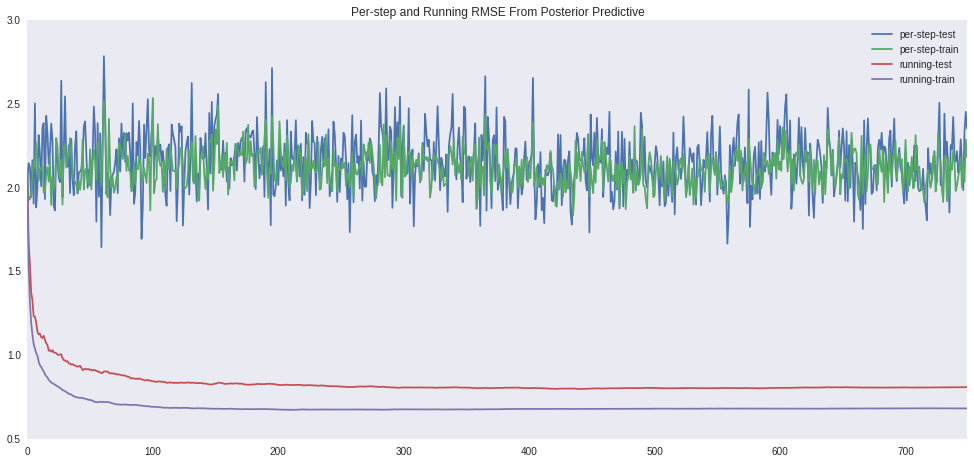

In [179]:
_,_,results_extendedhierarchical=extendedhierarchical_model.running_rmse(test, train,county_data, burn_in=5000)

In [180]:
results_extendedhierarchical.tail(3)

,per-step-test,per-step-train,running-test,running-train
747,2.334651,2.036358,0.808198,0.681845
748,2.454388,2.288047,0.808484,0.681869
749,2.353936,2.183702,0.808506,0.681677


After updating the plotting function, we can plot the predictions of the new model.

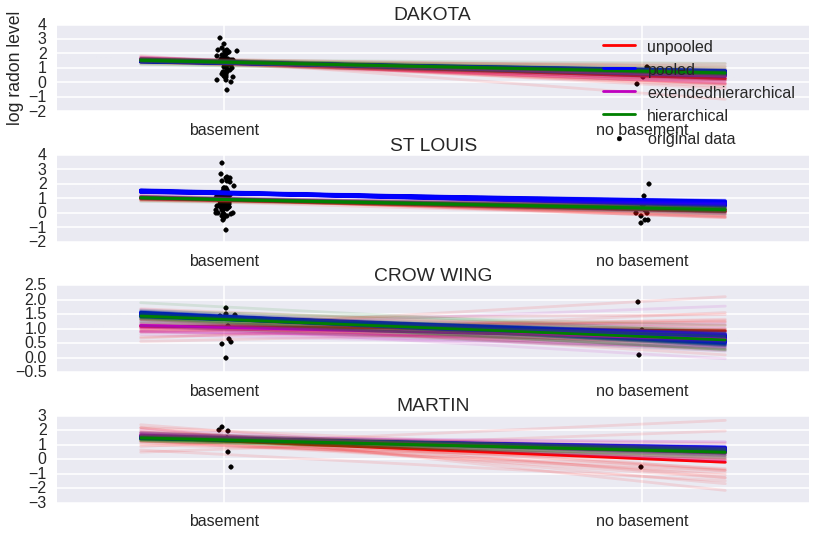

In [199]:
'''
    Igor Marfin <Unister Gmb, 2014> igor.marfin@unister.de
    
    plotting support for discussed models
'''


def plot_predictions(models,data,aux_data,selection):
    ''' plots predictions '''
    sns.set_context("poster")
    plt.figure(figsize=(15,8))
    
    fig = plt.figure(figsize=(12,8))
    
    data_copy = data.copy()
    data_copy=pd.merge(data_copy, aux_data, left_on='county', right_on='county_names', how='left')
    data_copy = data_copy.drop('county_names', 1)
    
    xvals = np.linspace(-0.2, 1.2) # range on the x-axis
    for i, c in enumerate(selection):
        c_data = data_copy.ix[data_copy["county"] == c]        
        c_data = c_data.reset_index(drop = True)        
        idx = list(c_data['county_idx'])[0] # contains county_idx for the selected county
        fig.add_subplot(str(len(selection))+'1'+str(i+1))        
        for model in models:
            if type(model) == ModelPooled:                
                traces = model.prepare_trace()
                alpha_trace=traces["alpha"].values[500::10]
                beta_trace=traces["beta"].values[500::10]                
                for j in range(len(alpha_trace)):
                    plot(xvals, alpha_trace[j] + beta_trace[j] * xvals, 'b', alpha=.1)
                plot(xvals, alpha_trace.mean() + beta_trace.mean() * xvals, 'b',label="pooled")

            elif type(model) == ModelUnPooled:
                traces = model.prepare_trace()
                alpha_trace=traces["alpha_%d"%idx].values[500::10]
                beta_trace=traces["beta_%d"%idx].values[500::10]
                #alpha_trace=traces["alpha_%d"%idx].values[50000::300]
                #beta_trace=traces["beta_%d"%idx].values[50000::300]
                for j in range(len(alpha_trace)):
                    plot(xvals, alpha_trace[j] + beta_trace[j] * xvals, 'r', alpha=.1)
                plot(xvals, alpha_trace.mean() + beta_trace.mean() * xvals, 'r',label="unpooled")                
            elif type(model) == ModelHierarchical:
                traces = model.prepare_trace()
                alpha_trace=traces["alpha_%d"%idx].values[500::10]
                beta_trace=traces["beta_%d"%idx].values[500::10]
                for j in range(len(alpha_trace)):
                    plot(xvals, alpha_trace[j] + beta_trace[j] * xvals, 'g', alpha=.1)
                plot(xvals, alpha_trace.mean() + beta_trace.mean() * xvals, 'g',label="hierarchical")
            elif type(model) == ModelExtendedHierarchical:            
                traces = model.prepare_trace()
                gamma0_trace = traces['gamma_0'].values[500::10]
                gamma1_trace = traces['gamma_1'].values[500::10]
                alpha_eps_trace =traces["alpha_eps_%d"%idx].values[500::10]
                beta_trace=traces["beta_%d"%idx].values[500::10]
                uranium = list(c_data['log_uranium'])[0]
                for j in range(len(beta_trace)):
                    plot(xvals, 
                         gamma0_trace[j] +gamma1_trace[j]*uranium + alpha_eps_trace[j]  
                          + beta_trace[j] * xvals, 'm', alpha=.1)                
                plot(xvals, 
                     gamma0_trace.mean() + gamma1_trace.mean()*uranium + 
                     alpha_eps_trace.mean() + 
                     beta_trace.mean() * xvals, 'm',label="extendedhierarchical")

# plot the original data                
        scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon, 
                   alpha=1, color='k', marker='.', s=80, label='original data')
        
        axis = plt.gca()
        axis.set_xticks([0,1])
        axis.set_xticklabels(['basement', 'no basement'])
        #axis.set_ylim(-0.1, 0.1)
        axis.set_title(c)        
        if not i%100:
            axis.legend()
            axis.set_ylabel('log radon level')



plot_predictions([unpooled_model,pooled_model,extendedhierarchical_model,hierarchical_model],train,county_data,[
        'DAKOTA','ST LOUIS','CROW WING','MARTIN'
    ])
            



$$\\[5pt]$$
References
----------------------

-------


<a id='Blog'></a>
[[1]http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)

<a id='Blog2'></a>
[[2]A Primer on Bayesian Methods for Multilevel Modeling](http://nbviewer.ipython.org/github/fonnesbeck/multilevel_modeling/blob/master/multilevel_modeling.ipynb)